### KNN
Investigate KNN performance. Results did not perform as well as logistic regression so it was not used in final results.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import calendar
import pickle

%matplotlib inline
plt.style.use('seaborn-pastel')

import seaborn as sns
sns.set(style="whitegrid")

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve

%run evaluation_functions.py

In [4]:
with open('pickles/appt_v2.pickle','rb') as read_file:
    appt = pickle.load(read_file)
    
appt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25453 entries, 1 to 39983
Data columns (total 31 columns):
PatientId              25453 non-null float64
AppointmentID          25453 non-null int64
Gender                 25453 non-null object
ScheduledDay           25453 non-null object
AppointmentDay         25453 non-null object
Age                    25453 non-null int64
Neighbourhood          25453 non-null object
Scholarship            25453 non-null int64
Hipertension           25453 non-null int64
Diabetes               25453 non-null int64
Alcoholism             25453 non-null int64
Handcap                25453 non-null int64
SMS_received           25453 non-null int64
No_show                25453 non-null object
No_show_num            25453 non-null int64
SchedDay               25453 non-null datetime64[ns]
SchedTime              25453 non-null object
SchedDayofWeek         25453 non-null object
ApptDay                25453 non-null datetime64[ns]
ApptDayofWeek          25453

In [6]:
#Set features
feature_cols = ['Gender','Age2','Neighbourhood2','Scholarship','Hipertension','Diabetes','Alcoholism',
                'Handcap_bin','SMS_received','SchedDayofWeek','ApptDayofWeek','DayDiff2',
                'PrevAppt_No_show','Reschedule','Follow_up']
# feature_cols = ['Gender','Age','Scholarship','Hipertension','Diabetes','Alcoholism','Handcap','SMS_received',
#                 'ApptDayofWeek','DayDiff']

a_X = appt[feature_cols]

a_X = pd.get_dummies(a_X, columns = ['Gender','Neighbourhood2','SchedDayofWeek','ApptDayofWeek'])
# a_X = pd.get_dummies(a_X, columns = ['Gender','ApptDayofWeek'],drop_first=True)

a_X.drop(columns=['Gender_F','Neighbourhood2_OTHER','SchedDayofWeek_Monday','ApptDayofWeek_Monday'],inplace=True)

X_cols = np.array(a_X.columns)
# a_X.info()
# a_X.head(5)

In [8]:
#split into training and test sets
X, y = a_X, appt['No_show_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10, stratify = y)

### Simple KNN train/test

In [30]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)

print("Train set: ",metrics.accuracy_score(y_train, y_pred_train))
print("Test set: ", metrics.accuracy_score(y_test, y_pred_test))
#train higher than test - overfitting on train data

Train set:  0.781968673057782
Test set:  0.6915461973601509


### Cross-validation KNN

In [12]:
from sklearn.model_selection import cross_val_score

In [13]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print(scores)

[0.69049489 0.68931658 0.68499607 0.6762279  0.67701375 0.68251473
 0.67779961 0.68290766 0.68683694 0.68330059]


In [14]:
# use average accuracy as an estimate of out-of-sample accuracy
print(scores.mean())

0.6831408720023087


In [22]:
# search for an optimal value of K for KNN
k_range = list(range(1, 50))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.6303387416140268, 0.6985421409136717, 0.6663260525003976, 0.7017245125833967, 0.6831408720023087, 0.7058494622328333, 0.6957522489918312, 0.7093852987158099, 0.7008600570716884, 0.7116644777354052, 0.7054965221457596, 0.7120967749403124, 0.7083643204718831, 0.7135897752474316, 0.7111144258029467, 0.71311850940726, 0.7116645394678968, 0.7152004531164877, 0.7113897681481951, 0.7159861071027861, 0.7134717272905455, 0.7159076451060796, 0.7144930296300525, 0.7179115435129182, 0.716418435173939, 0.7179114354810581, 0.717714879228097, 0.7177149100943427, 0.7166936077548357, 0.7181865154632174, 0.7166543458902366, 0.7179116052454099, 0.7174794469386085, 0.7178724051133023, 0.7172439683497516, 0.7175973714305115, 0.7169293641399044, 0.7174009232094105, 0.7170080267672084, 0.7187367680262734, 0.7182258699265538, 0.7177151570243088, 0.7174795395373458, 0.7177936807535068, 0.7174401079083952, 0.718265100924907, 0.7176364789638818, 0.7184222564151633, 0.7177936035878925]


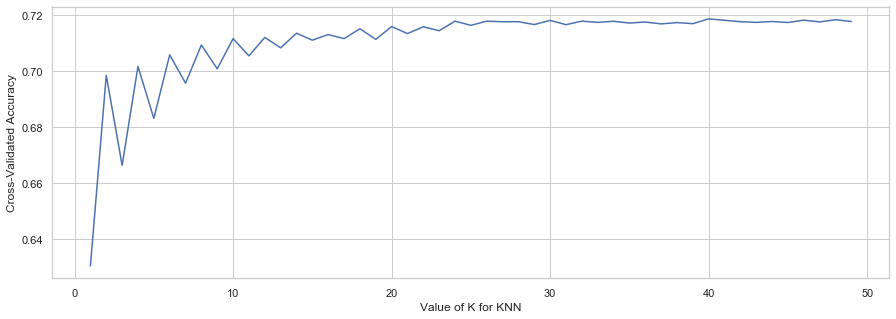

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.figure(figsize=(15,5))
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy');

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])

ROC AUC score =  0.5818119857398264


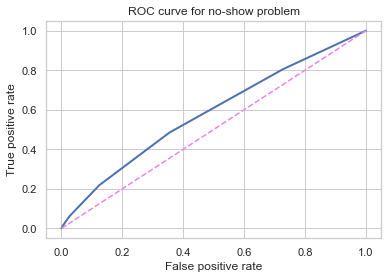

In [38]:
graph_roc_auc(fpr,tpr)
print("ROC AUC score = ", roc_auc_score(y_test, knn.predict_proba(X_test)[:,1]))

In [1]:
# KNN is not performing as well as logistic regression